In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#importing pythom classes and packages
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os
from keras.callbacks import ModelCheckpoint 
import pickle
from keras.layers import LSTM #load LSTM class
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten #load DNN dense layers
from keras.layers import Convolution2D #load CNN model
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from xgboost import XGBClassifier #load ML classes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [ ]:
#define minmax object for features normalization
scaler = MinMaxScaler(feature_range = (0, 1)) #use to normalize training data

In [ ]:
#load and display dataset values
dataset = pd.read_csv("Dataset/hpc_io_data.csv")
dataset.fillna(0, inplace = True)#replace missing values
dataset

,instructions,LLC-stores,L1-icache-load-misses,branch-load-misses,node-load-misses,rd_req,rd_bytes,wr_req,wr_bytes,flush_operations,rd_total_times,wr_total_times,flush_total_times,label
0,77556160.0,9575.0,257517.0,215949.0,0.0,0,0,8,147456,4,0,3596349,4524778,1
1,32981037.0,16800.0,797990.0,140417.0,2.0,0,0,0,0,0,0,0,0,1
2,11049222.0,5302.0,204689.0,55819.0,0.0,0,0,0,0,0,0,0,0,1
3,4968323.0,5252.0,188982.0,34310.0,0.0,0,0,0,0,0,0,0,0,1
4,15314480.0,11345.0,601098.0,112428.0,0.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,58694891.0,1827.0,9147.0,468151.0,0.0,0,0,0,0,0,0,0,0,0
5996,51471771.0,863.0,3740.0,521066.0,0.0,0,0,0,0,0,0,0,0,0
5997,49304168.0,5280.0,12560.0,480046.0,0.0,0,0,2,28672,1,0,503895,2094439,0
5998,55666764.0,13175.0,53589.0,529373.0,0.0,0,0,0,0,0,0,0,0,0


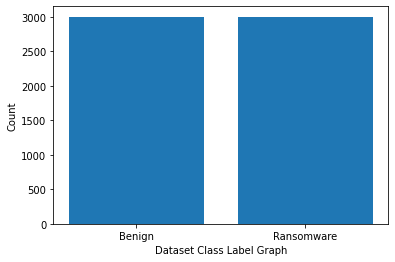

In [ ]:
#find and plot graph of ransomware and benign from dataset where 0 label refers as benign and 1 refer as ransomware
#plot labels in dataset
labels, count = np.unique(dataset['label'], return_counts = True)
labels = ['Benign', 'Ransomware']
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [ ]:
#dataset preprocessing such as normalization and shuffling
#data = dataset.values
#X = data[:,1:data.shape[1]-1]
#Y = data[:,data.shape[1]-1]
#Y = Y.astype(int)

#indices = np.arange(X.shape[0])
#np.random.shuffle(indices)#shuffle dataset values
#X = X[indices]
#Y = Y[indices]

#scaler = MinMaxScaler((0,1))
#X = scaler.fit_transform(X)#normalized or transform features
#print("Normalized Features")
#print(X)

In [ ]:
dataset.columns

Index(['instructions', 'LLC-stores', 'L1-icache-load-misses',
       'branch-load-misses', 'node-load-misses', 'rd_req', 'rd_bytes',
       'wr_req', 'wr_bytes', 'flush_operations', 'rd_total_times',
       'wr_total_times', 'flush_total_times', 'label'],
      dtype='object')

In [ ]:
X = dataset[['instructions', 'LLC-stores', 'L1-icache-load-misses',
       'branch-load-misses', 'node-load-misses', 'rd_req', 'rd_bytes',
       'wr_req', 'wr_bytes', 'flush_operations', 'rd_total_times',
       'wr_total_times', 'flush_total_times']]
Y = dataset['label']

In [ ]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 4800
Testing Size (20%): 1200



In [ ]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

ML_Model = []
acc = []
prec = []
rec = []
f1 = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    acc.append(round(a, 3))
    prec.append(round(b, 3))
    rec.append(round(c, 3))
    f1.append(round(d, 3))

In [ ]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

# SVM


SVM Accuracy  : 59.333333333333336
SVM Precision   : 75.76353066404651
SVM Recall      : 60.497781336536214
SVM FMeasure    : 52.883018576449224


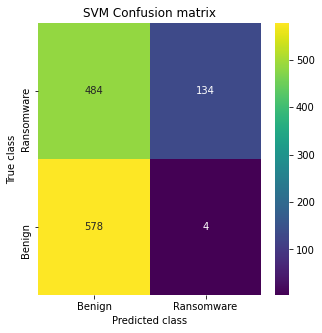

In [ ]:
#now train SVM algorithm on training features and then test on testing features to calculate accuracy and other metrics
svm_cls = svm.SVC(kernel="poly", gamma="scale", C=0.004)
svm_cls.fit(X_train, y_train)
predict = svm_cls.predict(X_test)
calculateMetrics("SVM", predict, y_test)

In [ ]:
svm_acc = accuracy_score(predict, y_test)
svm_prec = precision_score(predict, y_test,average='macro')
svm_rec = recall_score(predict, y_test,average='macro')
svm_f1 = f1_score(predict, y_test,average='macro')

storeResults('SVM',svm_acc,svm_prec,svm_rec,svm_f1)

# KNN


KNN Accuracy  : 90.41666666666667
KNN Precision   : 90.46816422153734
KNN Recall      : 90.48560371000566
KNN FMeasure    : 90.4165002864633


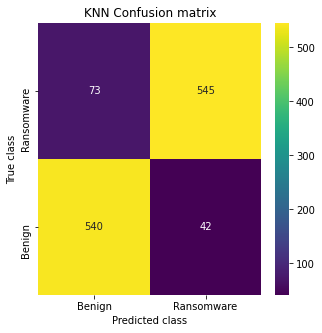

In [ ]:
#now training KNN algorithm
knn_cls =  KNeighborsClassifier(n_neighbors=500)
knn_cls.fit(X_train, y_train)
predict = knn_cls.predict(X_test)
calculateMetrics("KNN", predict, y_test)

In [ ]:
knn_acc = accuracy_score(predict, y_test)
knn_prec = precision_score(predict, y_test,average='macro')
knn_rec = recall_score(predict, y_test,average='macro')
knn_f1 = f1_score(predict, y_test,average='macro')

storeResults('KNN',knn_acc,knn_prec,knn_rec,knn_f1)

# Decision Tree


Decision Tree Accuracy  : 88.5
Decision Tree Precision   : 89.10492717137205
Decision Tree Recall      : 88.69482534280853
Decision Tree FMeasure    : 88.48307652077636


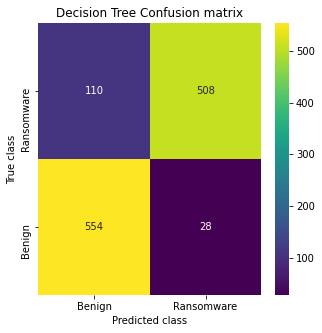

In [ ]:
#now train decision tree classifier with hyper parameters
dt_cls = DecisionTreeClassifier(criterion = "entropy",max_leaf_nodes=2,max_features="auto")#giving hyper input parameter values
dt_cls.fit(X_train, y_train)
predict = dt_cls.predict(X_test)
calculateMetrics("Decision Tree", predict, y_test)

In [ ]:
dt_acc = accuracy_score(predict, y_test)
dt_prec = precision_score(predict, y_test,average='macro')
dt_rec = recall_score(predict, y_test,average='macro')
dt_f1 = f1_score(predict, y_test,average='macro')

storeResults('Decision Tree',dt_acc,dt_prec,dt_rec,dt_f1)

# Random Forest


Random Forest Accuracy  : 98.5
Random Forest Precision   : 98.4944849670877
Random Forest Recall      : 98.50365328795915
Random Forest FMeasure    : 98.49879486587845


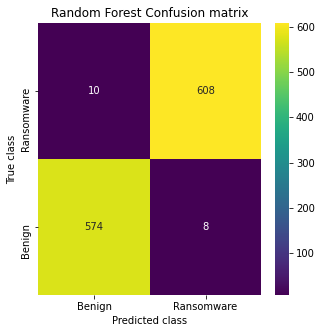

In [ ]:
#training random Forest algortihm
rf = RandomForestClassifier(n_estimators=40, criterion='gini', max_features="log2", min_weight_fraction_leaf=0.3)
rf.fit(X_train, y_train)
predict = rf.predict(X_test)
calculateMetrics("Random Forest", predict, y_test)

In [ ]:
rf_acc = accuracy_score(predict, y_test)
rf_prec = precision_score(predict, y_test,average='macro')
rf_rec = recall_score(predict, y_test,average='macro')
rf_f1 = f1_score(predict, y_test,average='macro')

storeResults('Random Froest',rf_acc,rf_prec,rf_rec,rf_f1)

# XGBoost


XGBoost Accuracy  : 99.16666666666667
XGBoost Precision   : 99.20382165605095
XGBoost Recall      : 99.14089347079039
XGBoost FMeasure    : 99.16544032759249


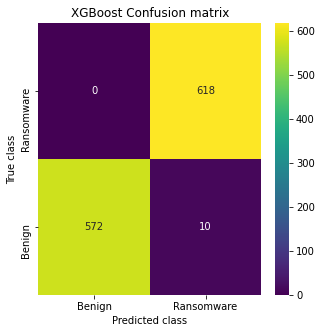

In [ ]:
#now train XGBoost algorithm
xgb_cls = XGBClassifier(n_estimators=10,learning_rate=0.09,max_depth=2)
xgb_cls.fit(X_train, y_train)
predict = xgb_cls.predict(X_test)
calculateMetrics("XGBoost", predict, y_test)

In [ ]:
rf_acc = accuracy_score(predict, y_test)
rf_prec = precision_score(predict, y_test,average='macro')
rf_rec = recall_score(predict, y_test,average='macro')
rf_f1 = f1_score(predict, y_test,average='macro')

storeResults('XGBoost',rf_acc,rf_prec,rf_rec,rf_f1)

# Voting Classifier


Voting Classifier Accuracy  : 99.5
Voting Classifier Precision   : 99.49194561483475
Voting Classifier Recall      : 99.50955860274246
Voting Classifier FMeasure    : 99.499644191425


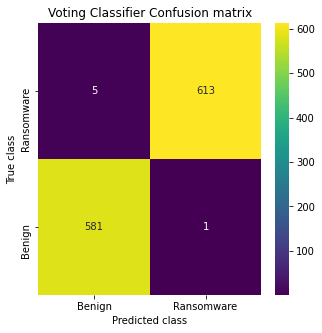

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
clf1 = AdaBoostClassifier(n_estimators=10, random_state=0)
clf2 = RandomForestClassifier(n_estimators=5, random_state=1)

eclf = VotingClassifier(estimators=[('ad', clf1), ('rf', clf2)], voting='soft')
eclf.fit(X_train, y_train)

predict = eclf.predict(X_test)
calculateMetrics("Voting Classifier", predict, y_test)

In [ ]:
rf_acc = accuracy_score(predict, y_test)
rf_prec = precision_score(predict, y_test,average='macro')
rf_rec = recall_score(predict, y_test,average='macro')
rf_f1 = f1_score(predict, y_test,average='macro')

storeResults('Voting Classifier',rf_acc,rf_prec,rf_rec,rf_f1)

# DNN

In [ ]:
#train DNN algortihm
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)
#define DNN object
dnn_model = Sequential()
#add DNN layers
dnn_model.add(Dense(2, input_shape=(X_train.shape[1],), activation='relu'))
dnn_model.add(Dense(2, activation='relu'))
dnn_model.add(Dropout(0.3))
dnn_model.add(Dense(y_train1.shape[1], activation='softmax'))
# compile the keras model
dnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#train and load the model
#if os.path.exists("model/dnn_weights.hdf5") == False:
   # model_check_point = ModelCheckpoint(filepath='model/dnn_weights.hdf5', verbose = 1, save_best_only = True)
hist = dnn_model.fit(X_train, y_train1, batch_size = 32, epochs = 10, validation_data=(X_test, y_test1),  verbose=1)
   # f = open('model/dnn_history.pckl', 'wb')
   # pickle.dump(hist.history, f)
  #  f.close()    
#else:
   # dnn_model.load_weights("model/dnn_weights.hdf5")
#perform prediction on test data    



Epoch 1/10
150/150 [==============================] - 11s 5ms/step - loss: 3540.8101 - accuracy: 0.6033 - val_loss: 0.6087 - val_accuracy: 0.6017
Epoch 2/10
150/150 [==============================] - 0s 3ms/step - loss: 1624.2755 - accuracy: 0.5816 - val_loss: 0.6211 - val_accuracy: 0.5850
Epoch 3/10
150/150 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.5702 - val_loss: 0.6211 - val_accuracy: 0.5850
Epoch 4/10
150/150 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.5813 - val_loss: 0.6211 - val_accuracy: 0.5850
Epoch 5/10
150/150 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.5747 - val_loss: 0.6211 - val_accuracy: 0.5850
Epoch 6/10
150/150 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.5898 - val_loss: 0.6211 - val_accuracy: 0.5850
Epoch 7/10
150/150 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.5751 - val_loss: 0.6211 - val_accuracy: 0.5850


DNN Accuracy  : 58.5
DNN Precision   : 76.94444444444444
DNN Recall      : 59.70873786407766
DNN FMeasure    : 51.27821314314227


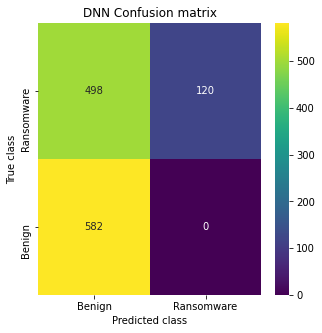

In [ ]:
predict = dnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("DNN", predict, testY)#call function to calculate accuracy and other metrics

In [ ]:
rf_acc = accuracy_score(predict, testY)
rf_prec = precision_score(predict, testY,average='macro')
rf_rec = recall_score(predict, testY,average='macro')
rf_f1 = f1_score(predict, testY,average='macro')

storeResults('DNN',rf_acc,rf_prec,rf_rec,rf_f1)

# LSTM

In [ ]:
X_train = X_train.values
X_test = X_test.values

In [ ]:
#now train LSTM algorithm
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
lstm_model = Sequential()#defining deep learning sequential object
#adding LSTM layer with 100 filters to filter given input X train data to select relevant features
lstm_model.add(LSTM(32,input_shape=(X_train1.shape[1], X_train1.shape[2])))
#adding dropout layer to remove irrelevant features
lstm_model.add(Dropout(0.2))
#adding another layer
lstm_model.add(Dense(32, activation='relu'))
#defining output layer for prediction
lstm_model.add(Dense(y_train1.shape[1], activation='softmax'))
#compile LSTM model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#train and load the model
#if os.path.exists("model/lstm_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/lstm_weights.hdf5', verbose = 1, save_best_only = True)
hist = lstm_model.fit(X_train1, y_train1, batch_size = 32, epochs = 10, validation_data=(X_test1, y_test1), verbose=1)
    #f = open('model/lstm_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close()    
#else:
   # lstm_model.load_weights("model/lstm_weights.hdf5")
#perform prediction on test data    


Epoch 1/10
150/150 [==============================] - 5s 7ms/step - loss: 0.4540 - accuracy: 0.8317 - val_loss: 0.2058 - val_accuracy: 0.9233
Epoch 2/10
150/150 [==============================] - 1s 4ms/step - loss: 0.2101 - accuracy: 0.9210 - val_loss: 0.1451 - val_accuracy: 0.9592
Epoch 3/10
150/150 [==============================] - 1s 4ms/step - loss: 0.1625 - accuracy: 0.9481 - val_loss: 0.1400 - val_accuracy: 0.9600
Epoch 4/10
150/150 [==============================] - 1s 4ms/step - loss: 0.1648 - accuracy: 0.9449 - val_loss: 0.1482 - val_accuracy: 0.9508
Epoch 5/10
150/150 [==============================] - 1s 4ms/step - loss: 0.1639 - accuracy: 0.9431 - val_loss: 0.1521 - val_accuracy: 0.9492
Epoch 6/10
150/150 [==============================] - 1s 4ms/step - loss: 0.1573 - accuracy: 0.9453 - val_loss: 0.1422 - val_accuracy: 0.9542
Epoch 7/10
150/150 [==============================] - 1s 4ms/step - loss: 0.1500 - accuracy: 0.9497 - val_loss: 0.1371 - val_accuracy: 0.9550
Epoch 


LSTM Accuracy  : 96.0
LSTM Precision   : 96.0600771531167
LSTM Recall      : 96.07646882193974
LSTM FMeasure    : 95.99995555506172


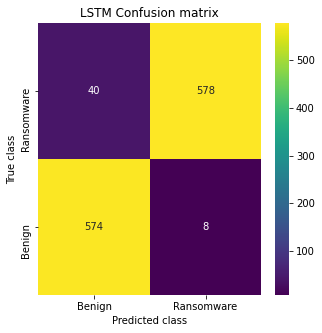

In [ ]:
predict = lstm_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("LSTM", predict, testY)#call function to calculate accuracy and other metrics

In [ ]:
rf_acc = accuracy_score(predict, testY)
rf_prec = precision_score(predict, testY,average='macro')
rf_rec = recall_score(predict, testY,average='macro')
rf_f1 = f1_score(predict, testY,average='macro')

storeResults('LSTM',rf_acc,rf_prec,rf_rec,rf_f1)

# CNN

In [ ]:
#now train extension CNN algorithm
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))

In [ ]:

#define extension CNN model object
cnn_model = Sequential()
#adding CNN layer wit 32 filters to optimized dataset features using 32 neurons
cnn_model.add(Convolution2D(64, (1, 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
#adding maxpooling layer to collect filtered relevant features from previous CNN layer
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#adding another CNN layer to further filtered features
cnn_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#collect relevant filtered features
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))
#defining output layers
cnn_model.add(Dense(units = 256, activation = 'relu'))
#defining prediction layer with Y target data
cnn_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
#compile the CNN with LSTM model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#train and load the model
#if os.path.exists("model/cnn_weights.hdf5") == False:
   # model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
hist = cnn_model.fit(X_train1, y_train1, batch_size = 8, epochs = 10, validation_data=(X_test1, y_test1), verbose=1)
   # f = open('model/cnn_history.pckl', 'wb')
   # pickle.dump(hist.history, f)
   # f.close()    
#else:
    #cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data        

Epoch 1/10
600/600 [==============================] - 5s 4ms/step - loss: 100982.5055 - accuracy: 0.8737 - val_loss: 0.1938 - val_accuracy: 0.9350
Epoch 2/10
600/600 [==============================] - 2s 4ms/step - loss: 0.1772 - accuracy: 0.9376 - val_loss: 0.1581 - val_accuracy: 0.9350
Epoch 3/10
600/600 [==============================] - 2s 4ms/step - loss: 0.1638 - accuracy: 0.9441 - val_loss: 0.1487 - val_accuracy: 0.9525
Epoch 4/10
600/600 [==============================] - 2s 4ms/step - loss: 0.1509 - accuracy: 0.9462 - val_loss: 0.1400 - val_accuracy: 0.9583
Epoch 5/10
600/600 [==============================] - 2s 4ms/step - loss: 0.1559 - accuracy: 0.9465 - val_loss: 0.1357 - val_accuracy: 0.9550
Epoch 6/10
600/600 [==============================] - 2s 4ms/step - loss: 0.1413 - accuracy: 0.9521 - val_loss: 0.1399 - val_accuracy: 0.9592
Epoch 7/10
600/600 [==============================] - 2s 4ms/step - loss: 0.1476 - accuracy: 0.9547 - val_loss: 0.1340 - val_accuracy: 0.9558
E


Extension CNN2D Accuracy  : 95.58333333333333
Extension CNN2D Precision   : 95.70799869808691
Extension CNN2D Recall      : 95.68194708571048
Extension CNN2D FMeasure    : 95.58325665376135


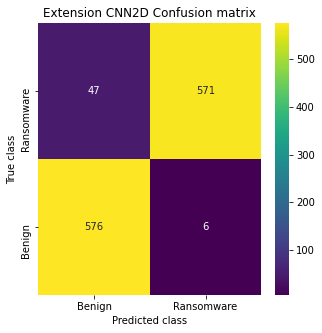

In [ ]:
predict = cnn_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("Extension CNN2D", predict, testY)#call function to calculate accuracy and other metrics

In [ ]:
rf_acc = accuracy_score(predict, testY)
rf_prec = precision_score(predict, testY,average='macro')
rf_rec = recall_score(predict, testY,average='macro')
rf_f1 = f1_score(predict, testY,average='macro')

storeResults('Extension CNN2D',rf_acc,rf_prec,rf_rec,rf_f1)

# Comparison

In [ ]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : acc,
                       'Precision': prec,
                       'Recall'   : rec,
                        'f1_score' : f1,
                      })

In [ ]:
result

,ML Model,Accuracy,Precision,Recall,f1_score
0,SVM,0.593,0.605,0.758,0.529
1,KNN,0.904,0.905,0.905,0.904
2,Decision Tree,0.885,0.887,0.891,0.885
3,Random Froest,0.985,0.985,0.985,0.985
4,XGBoost,0.992,0.991,0.992,0.992
5,Voting Classifier,0.995,0.995,0.995,0.995
6,DNN,0.585,0.597,0.769,0.513
7,LSTM,0.960,0.961,0.961,0.960
8,Extension CNN2D,0.956,0.957,0.957,0.956


# Modelling

In [ ]:
import joblib
filename = 'model.sav'
joblib.dump(eclf, filename)

['model.sav']

# Graph

In [ ]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

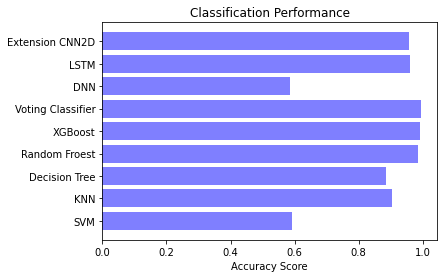

In [ ]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, acc, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

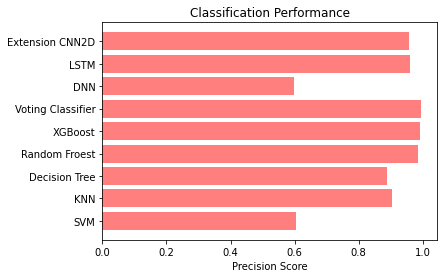

In [ ]:
plt2.barh(y_pos, prec, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

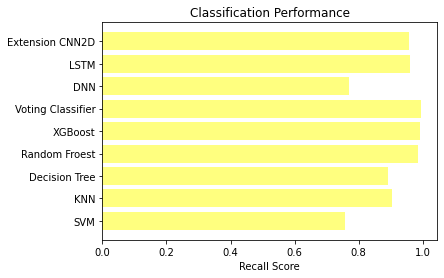

In [ ]:
plt2.barh(y_pos, rec, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

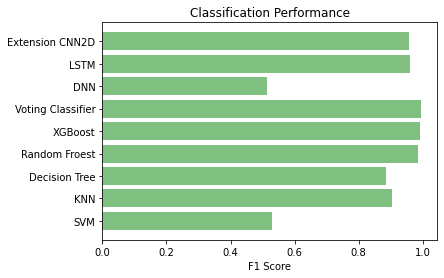

In [ ]:
plt2.barh(y_pos, f1, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()